# Libraries

In [34]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
from ucimlrepo import fetch_ucirepo  
from sklearn.feature_selection import mutual_info_classif
from sklearn.feature_selection import SelectKBest
import pandas as pd
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

# Load Data

In [35]:
bank_marketing = fetch_ucirepo(id=222) 
X = bank_marketing.data.features 
y = bank_marketing.data.targets 

In [36]:
X

,age,job,marital,education,default,balance,housing,loan,contact,day_of_week,month,duration,campaign,pdays,previous,poutcome
0,58,management,married,tertiary,no,2143,yes,no,NaN,5,may,261,1,-1,0,NaN
1,44,technician,single,secondary,no,29,yes,no,NaN,5,may,151,1,-1,0,NaN
2,33,entrepreneur,married,secondary,no,2,yes,yes,NaN,5,may,76,1,-1,0,NaN
3,47,blue-collar,married,NaN,no,1506,yes,no,NaN,5,may,92,1,-1,0,NaN
4,33,NaN,single,NaN,no,1,no,no,NaN,5,may,198,1,-1,0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45206,51,technician,married,tertiary,no,825,no,no,cellular,17,nov,977,3,-1,0,NaN
45207,71,retired,divorced,primary,no,1729,no,no,cellular,17,nov,456,2,-1,0,NaN
45208,72,retired,married,secondary,no,5715,no,no,cellular,17,nov,1127,5,184,3,success
45209,57,blue-collar,married,secondary,no,668,no,no,telephone,17,nov,508,4,-1,0,NaN


# Data Clasification 

In [37]:
def classify_columns(data_frame):
    categorical_columns = data_frame.select_dtypes(include=['object']).columns
    numeric_columns = data_frame.select_dtypes(include=['int64', 'float64']).columns
    return list(categorical_columns), list(numeric_columns)
categorical_columns, numeric_columns = classify_columns(X)
print("Categorical Columns:", categorical_columns)
print("Numerical Columns:", numeric_columns)


Categorical Columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome']
Numerical Columns: ['age', 'balance', 'day_of_week', 'duration', 'campaign', 'pdays', 'previous']


# Remove Dublicaties 

In [38]:
def removeDuplicates(df):
    df_copy = df.copy()  
    df_copy.drop_duplicates(inplace=True)
    missing_values = df_copy.isnull().sum()
    print("Missing Values:\n", missing_values)
removeDuplicates(X)


Missing Values:
 age                0
job              288
marital            0
education       1857
default            0
balance            0
housing            0
loan               0
contact        13020
day_of_week        0
month              0
duration           0
campaign           0
pdays              0
previous           0
poutcome       36959
dtype: int64


# Data Describe 

In [39]:
def summary(df):
    summary_stats = df.describe()
    print("Summary Statistics:\n", summary_stats)
summary(X)
    

Summary Statistics:
                 age        balance   day_of_week      duration      campaign  \
count  45211.000000   45211.000000  45211.000000  45211.000000  45211.000000   
mean      40.936210    1362.272058     15.806419    258.163080      2.763841   
std       10.618762    3044.765829      8.322476    257.527812      3.098021   
min       18.000000   -8019.000000      1.000000      0.000000      1.000000   
25%       33.000000      72.000000      8.000000    103.000000      1.000000   
50%       39.000000     448.000000     16.000000    180.000000      2.000000   
75%       48.000000    1428.000000     21.000000    319.000000      3.000000   
max       95.000000  102127.000000     31.000000   4918.000000     63.000000   

              pdays      previous  
count  45211.000000  45211.000000  
mean      40.197828      0.580323  
std      100.128746      2.303441  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%   

# Preprocessing 

In [ ]:
def preprocess_categorical_data(data_frame, column_name):
    imputer = SimpleImputer(strategy='most_frequent')
    transformed_values = imputer.fit_transform(data_frame[[column_name]])
    data_frame[column_name] = transformed_values.ravel() 
    label_encoder = LabelEncoder()
    data_frame[column_name] = label_encoder.fit_transform(data_frame[column_name])

    return data_frame
def preprocess_numeric_data(data_frame, column_name):
    imputer = SimpleImputer(strategy='median')
    data_frame[column_name] = imputer.fit_transform(data_frame[[column_name]])
    scaler = StandardScaler()
    data_frame[column_name] = scaler.fit_transform(data_frame[[column_name]])

    return data_frame
def preprocess_target_variable(y):
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(y)
    encoded_classes = label_encoder.classes_

    return y_encoded, encoded_classes
for column_name in categorical_columns:
    X = preprocess_categorical_data(X, column_name)
for column_name in numeric_columns:
    X = preprocess_numeric_data(X, column_name)
y, encoded_classes = preprocess_target_variable(y)



# Check the result of Preprocessing 

In [41]:
missing_values = X.isnull().sum()
print(missing_values)

age            0
job            0
marital        0
education      0
default        0
balance        0
housing        0
loan           0
contact        0
day_of_week    0
month          0
duration       0
campaign       0
pdays          0
previous       0
poutcome       0
dtype: int64


# Rmove Outliers

In [42]:
def remove_outliers(df, multiplier=2):
    for column in df.columns:
        if df[column].dtype in ['int64', 'float64']:
            q1 = df[column].quantile(0.25)
            q3 = df[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - multiplier * iqr
            upper_bound = q3 + multiplier * iqr
            df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df
X = remove_outliers(X)


# Feature Selection 

In [43]:
def select_features(X, y, k=5):
    if len(X) != len(y):
        raise ValueError("Number of samples in X and y are inconsistent.")
    selector = SelectKBest(score_func=mutual_info_classif, k=k)
    X_selected = selector.fit_transform(X, y)
    selected_indices = selector.get_support(indices=True)
    selected_feature_names = X.columns[selected_indices]
    X_selected_df = pd.DataFrame(X_selected, columns=selected_feature_names)
    
    return X_selected_df, selected_feature_names
y = y[:len(X)]
X, selected_feature_names = select_features(X, y, k=5)


# Plots 

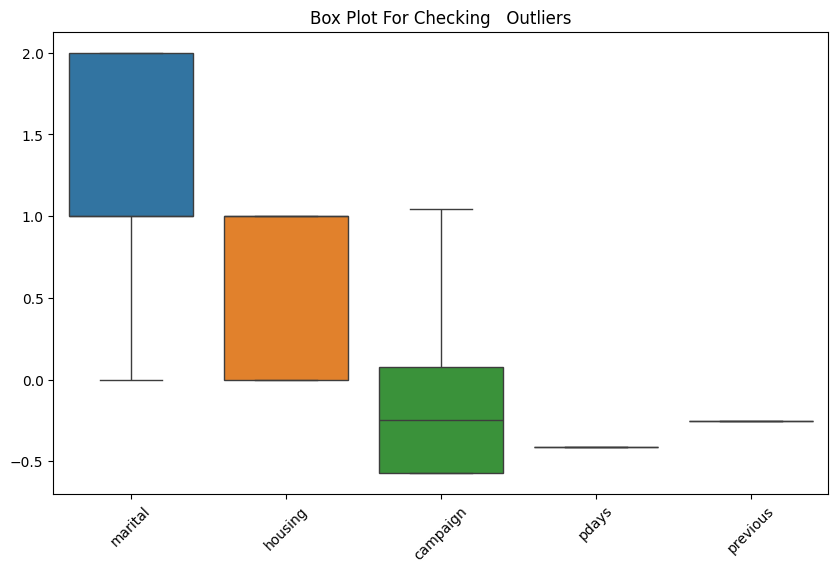

In [44]:
def plot_box_plots(data):
    plt.figure(figsize=(10, 6))
    sns.boxplot(data=data)
    plt.title("Box Plot For Checking   Outliers")
    plt.xticks(rotation=45)
    plt.show()
plot_box_plots(X)

# Build Decision TREE ANd TRain Clasifier

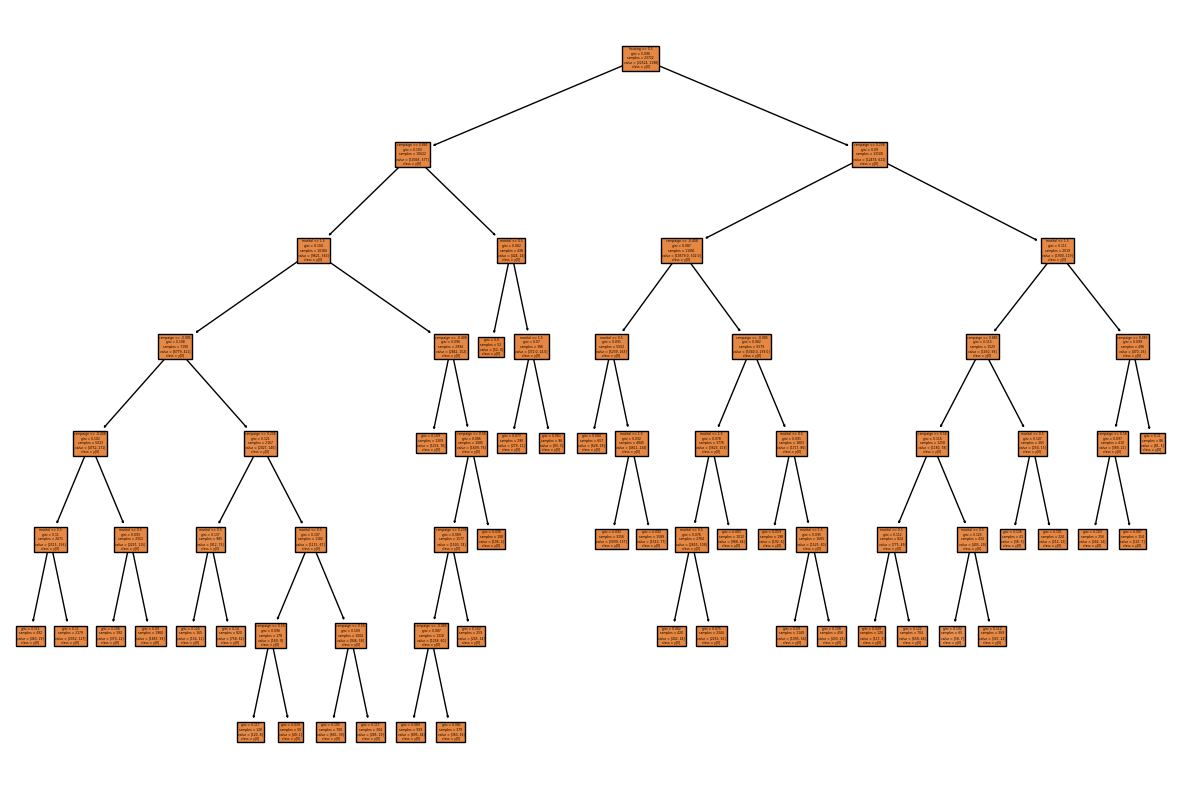

Classification Report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97      5633
           1       0.00      0.00      0.00       298

    accuracy                           0.95      5931
   macro avg       0.47      0.50      0.49      5931
weighted avg       0.90      0.95      0.93      5931



c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\mahma\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [45]:
def build_decision_tree_with_plot(X, y, test_size=0.2, random_state=42, max_depth=3):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    classifier = DecisionTreeClassifier(random_state=random_state, max_depth=max_depth)
    classifier.fit(X_train, y_train)
    plt.figure(figsize=(15, 10))
    plot_tree(classifier, filled=True, feature_names=X.columns, class_names=True)
    plt.show()
    y_pred = classifier.predict(X_test)
    report = classification_report(y_test, y_pred)
    
    return classifier, report
y = y[:len(X)]
classifier, report = build_decision_tree_with_plot(X, y, test_size=0.2, random_state=42, max_depth=16)
print("Classification Report:\n", report)



